In [4]:
import sys
import os

sys.path.append(os.path.abspath("../"))

import jax.numpy as jnp
import jax.nn as jnn
from src.fd_scheme import fd_solve
from src.analytical import u_exact
from src.plotting import plot_solution, plot_training_loss, plot_all_heatmaps, plot_scheme_errors_t1, plot_scheme_errors_t2
from src.nn.model import MLP
from src.nn.train import train_pinn
from src.nn.evaluation import compare_nn_and_exact, test_explicit_scheme
from src.experiment import run_architecture_sweep

# Part B
Plots for $\Delta x = 1/10$ and $\Delta t = 1/100$

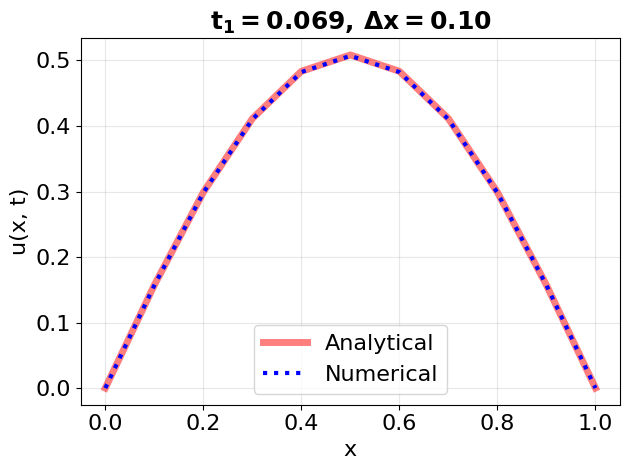

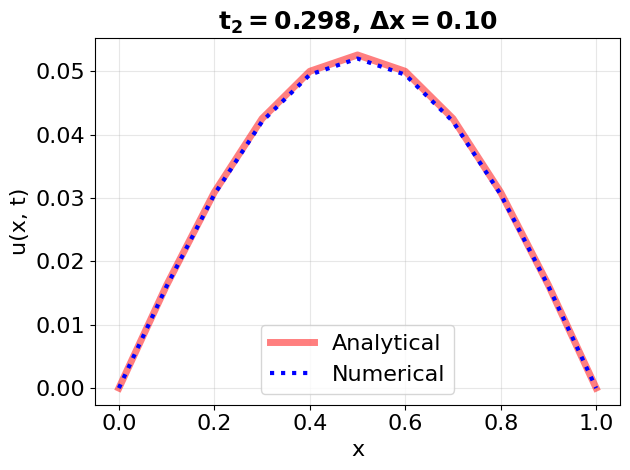

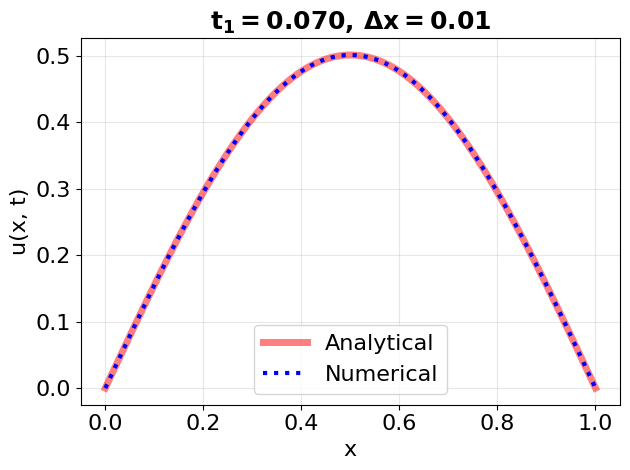

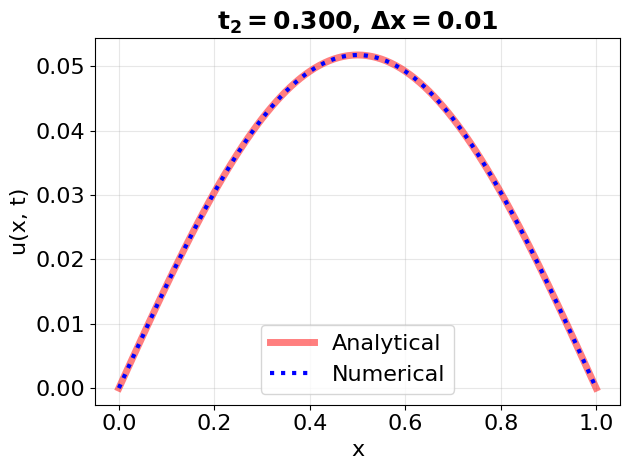

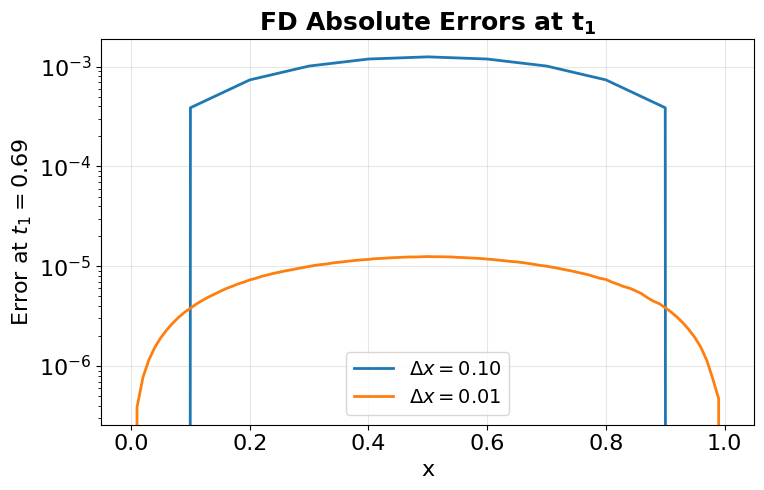

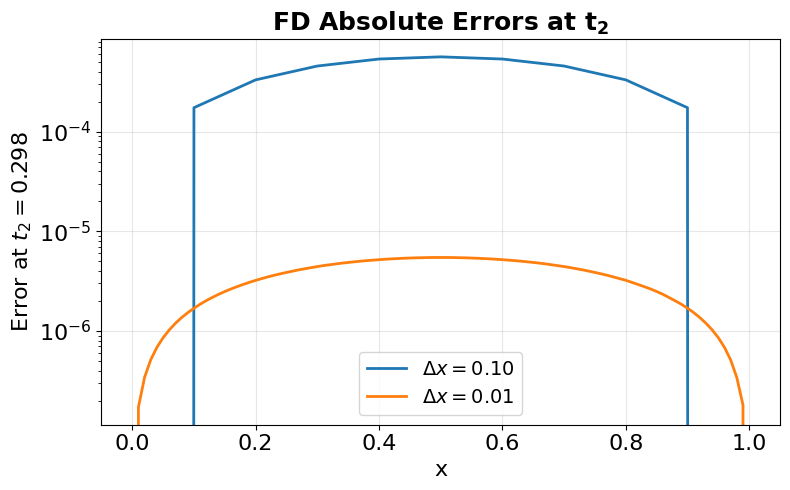

In [2]:
errors = []
errors.append(test_explicit_scheme(Nx=10))
errors.append(test_explicit_scheme(Nx=100))

plot_scheme_errors_t1(errors, title=r"FD Absolute Errors at $\mathbf{{t_1}}$", filepath="../figs/errors_t1.pdf")
plot_scheme_errors_t2(errors, title=r"FD Absolute Errors at $\mathbf{{t_2}}$", filepath="../figs/errors_t2.pdf")

# Part C
Solving same problem as for part b, but now using PINNS

In [ ]:
# ---------- Part c — PINN version of part b ----------
Nx = 100
T = 0.5

_, x, t = fd_solve(Nx=Nx, T=T, alpha=0.4)
u_true = u_exact(x, t)

t1, t2 = 0.07, 0.30
i1 = jnp.argmin(jnp.abs(t - t1))
i2 = jnp.argmin(jnp.abs(t - t2))

model, losses = train_pinn(
    layers=[2, 128, 128, 128, 128, 1], 
    steps=1000,
    N_int=1000,            
    N_ic=200,
    lambda_ic=1.0,
    lambda_bc=1.0,        
    lr=1e-3,
    nu=1.0, 
)

u_pinn, _, _, _ = compare_nn_and_exact(model, Nx=Nx, T=T, return_only=True)


plot_solution(
    x,
    u_pinn[i1],
    u_true[i1],
    title=rf"PINN vs exact at t_1 \approx {float(t[i1]):.3f}",
)

plot_solution(
    x,
    u_pinn[i2],
    u_true[i2],
    title=rf"PINN vs exact at t_2 \approx {float(t[i2]):.3f}",
)

compare_nn_and_exact(model, Nx=Nx, T=T)

plot_training_loss(losses)


# Part d)

Loading pre-computed results from CSV files...
Loaded ../data/sweep_tanh.csv
Loaded ../data/sweep_sine.csv
Loaded ../data/sweep_GeLU.csv
Loaded ../data/sweep_SiLU.csv
Loaded ../data/sweep_ReLU.csv

Loaded 450 individual results
Aggregated to 45 configurations
Creating heatmap for activation: GeLU


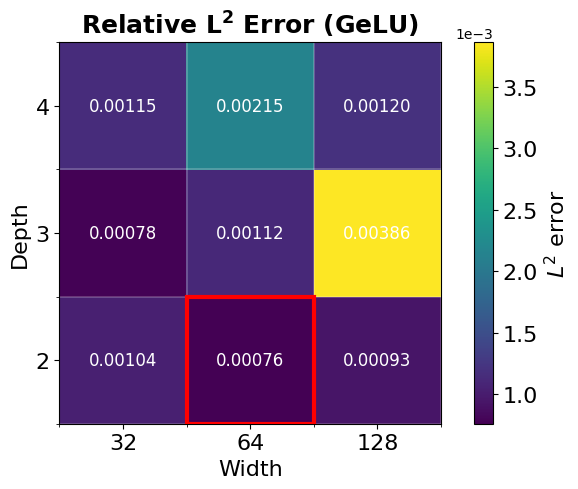

Saved: ../figs/heatmap_activation_GeLU.pdf
Creating heatmap for activation: ReLU


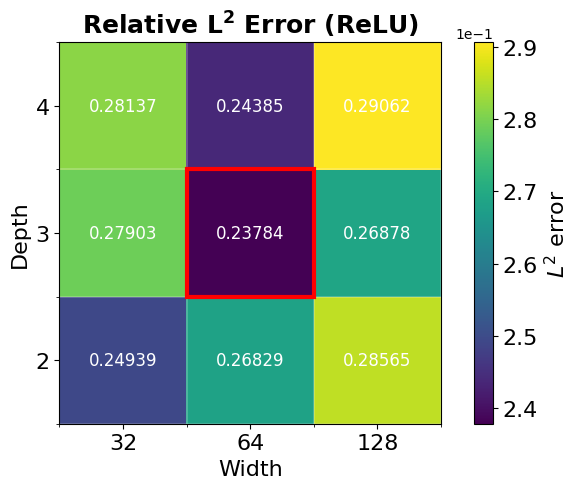

Saved: ../figs/heatmap_activation_ReLU.pdf
Creating heatmap for activation: SiLU


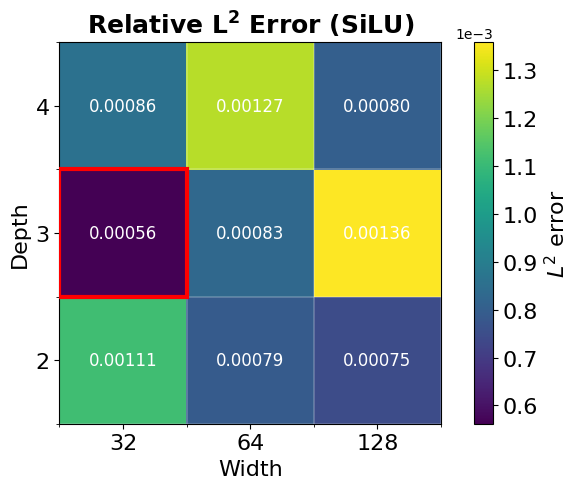

Saved: ../figs/heatmap_activation_SiLU.pdf
Creating heatmap for activation: sine


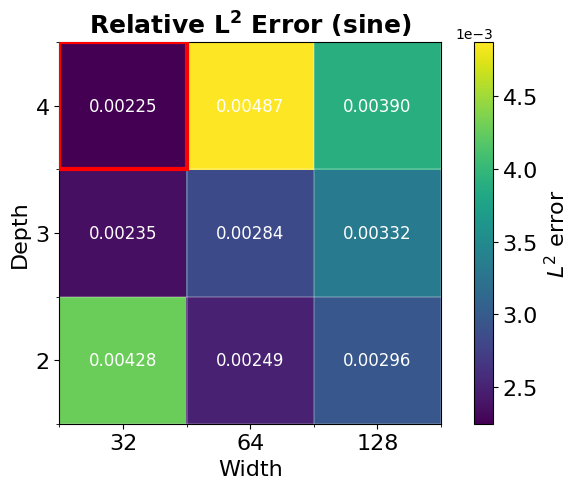

Saved: ../figs/heatmap_activation_sine.pdf
Creating heatmap for activation: tanh


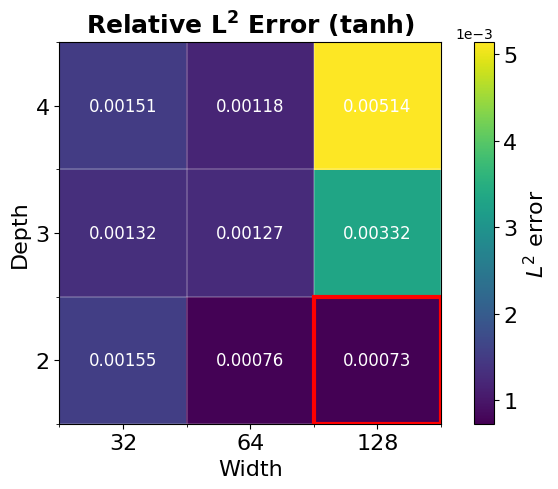

Saved: ../figs/heatmap_activation_tanh.pdf


In [6]:
results = run_architecture_sweep(
    hidden_widths=[32, 64, 128],
    num_hidden_layers=[2, 3, 4],
    activation_fns={
        'tanh': jnn.tanh,
        'sine': jnp.sin,
        'GeLU': jnn.gelu,
        'SiLU': jnn.swish,
        'ReLU': jnn.relu,
    },
    T=0.5,
    steps=10000,
    N_int=1000,
    N_bc=500,
    N_ic=200,
    lr=5e-4,
    seeds=(4, 2, 16, 8, 29, 3, 21, 9, 0, 42),
    save_to_csv=False,
    use_pre_computed=True,
    data_dir="../data",
)

plot_all_heatmaps(results, save_dir="../figs", show=True)

In [ ]:
print(results)